# Denna är inte samma som efterföjnade, kika på gtd200 osv

In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from build_graph_data import *
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
partition = 100

In [3]:
trainpath = f'../../../data/top30groups/LongLatCombined/train1/train{partition}.csv'
testpath = f'../../../data/top30groups/LongLatCombined/test1/test{partition}.csv'
traindata = pd.read_csv(trainpath, encoding='ISO-8859-1')
testdata = pd.read_csv(testpath, encoding='ISO-8859-1')

In [4]:
traindata.columns

Index(['extended', 'latitude', 'longitude', 'vicinity', 'multiple', 'success',
       'suicide', 'attacktype1', 'targtype1', 'target1', 'individual',
       'weaptype1', 'nkill', 'property', 'ishostkid', 'gname'],
      dtype='object')

In [5]:
combined = pd.concat([traindata, testdata], axis = 0)

In [6]:
combined.shape

(3000, 16)

In [7]:
data = combined

In [8]:
data.columns

Index(['extended', 'latitude', 'longitude', 'vicinity', 'multiple', 'success',
       'suicide', 'attacktype1', 'targtype1', 'target1', 'individual',
       'weaptype1', 'nkill', 'property', 'ishostkid', 'gname'],
      dtype='object')

In [9]:
# Filter dataset to only contain unique coordinates
print("Entries before dropping long/lat duplicates: ", data.shape)

#data.sort_values(by=['longitude', 'latitude', 'attack_date'], inplace=True)

# Keep only relevant columns
data = data[['longitude', 'latitude', 'gname']]
# Drop duplicates based on location, keep the earliest attack
data['longlat'] = list(zip(data['longitude'], data['latitude']))
df_unique = data.drop_duplicates(subset=['longlat'], keep='first').reset_index(drop=True)

df_unique = df_unique.drop(columns=['longitude', 'latitude'])
print(df_unique.columns)
print("Entries after dropping long/lat duplicates (#Nodes): ", df_unique.shape)


Entries before dropping long/lat duplicates:  (3000, 16)
Index(['gname', 'longlat'], dtype='object')
Entries after dropping long/lat duplicates (#Nodes):  (1790, 2)


/tmp/ipykernel_54384/691971201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['longlat'] = list(zip(data['longitude'], data['latitude']))


In [10]:
df_unique["gname"].value_counts()

gname
New People's Army (NPA)                             97
Maoists                                             92
Taliban                                             91
Fulani extremists                                   91
Kurdistan Workers' Party (PKK)                      88
Communist Party of India - Maoist (CPI-Maoist)      85
Nicaraguan Democratic Force (FDN)                   83
Revolutionary Armed Forces of Colombia (FARC)       78
Abu Sayyaf Group (ASG)                              71
Boko Haram                                          68
Liberation Tigers of Tamil Eelam (LTTE)             66
Farabundo Marti National Liberation Front (FMLN)    65
Muslim extremists                                   65
Tehrik-i-Taliban Pakistan (TTP)                     64
Islamic State of Iraq and the Levant (ISIL)         57
National Liberation Army of Colombia (ELN)          56
Sikh Extremists                                     55
Al-Qaida in the Arabian Peninsula (AQAP)            51
Afri

In [11]:
split_point = int(0.7 * len(df_unique))
train_df = df_unique[:split_point]
test_df = df_unique[split_point:]

In [12]:
import ast

def to_tuple_if_needed(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val  # already a tuple

df_unique['longlat'] = df_unique['longlat'].apply(to_tuple_if_needed)


In [13]:
from sklearn.model_selection import train_test_split

# 1. Build coord_to_index from the full dataset
full_coords = df_unique[['longlat']]
coord_to_index = {row['longlat']: i for i, row in full_coords.iterrows()}

# 2. Build the global graph
adj_matrix, feature_matrix, label_index = build_graph_data(df_unique, coord_to_index)

# 3. Build train node indices and labels
train_nodes = [coord_to_index[row['longlat']] for _, row in train_df.iterrows()]
train_labels = [label_index[row['gname']] for _, row in train_df.iterrows()]

# 4. Split train into train and validation
train_idx, val_idx, train_lbls, val_lbls = train_test_split(
    train_nodes, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# 5. Build test node indices and labels
test_nodes = [coord_to_index[row['longlat']] for _, row in test_df.iterrows()]
test_labels = [label_index[row['gname']] for _, row in test_df.iterrows()]


Number of total nodes (unique coordinates): 1790
Number of unique labels in this set: 30


In [14]:
print(adj_matrix.shape)

(1790, 1790)


# A simple GCN

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class PyTorchGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.0, activation=F.relu):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout
        self.activation = activation

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


/opt/conda/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [26]:
def run_epoch(model, data, labels, mask, optimizer=None, return_preds=False):
    is_training = optimizer is not None
    if is_training:
        model.train()
    else:
        model.eval()

    out = model(data.x, data.edge_index)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(out[mask], labels[mask])

    if is_training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pred = out[mask].argmax(dim=1)
    acc = (pred == labels[mask]).float().mean().item()

    if return_preds:
        return acc, loss.item(), pred.cpu(), labels[mask].cpu(), out[mask].softmax(dim=1).cpu()
    else:
        return acc, loss.item()


In [17]:
from torch_geometric.data import Data
from scipy.sparse import coo_matrix

# 1. Convert adjacency matrix to edge_index
A_coo = coo_matrix(adj_matrix)
edge_index = torch.tensor(np.vstack((A_coo.row, A_coo.col)), dtype=torch.long)

# 2. Feature matrix
coords = np.array(list(coord_to_index.keys()), dtype=np.float32)
x = torch.tensor(coords, dtype=torch.float32)
num_nodes = x.shape[0]

# 3. Label tensor
y = torch.full((num_nodes,), -1, dtype=torch.long)

# 4. Masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# 5. Assign labels and masks
for idx, label in zip(train_idx, train_lbls):
    y[idx] = label
    train_mask[idx] = True

for idx, label in zip(val_idx, val_lbls):
    y[idx] = label
    val_mask[idx] = True

for idx, label in zip(test_nodes, test_labels):
    y[idx] = label
    test_mask[idx] = True

# 6. Create PyG data object
data = Data(x=x, edge_index=edge_index)


In [22]:
from itertools import product

hidden_dims = [10, 50, 100, 150, 200, 300]
lrs = [0.01, 0.001, 0.0001]
weight_decays = [0, 5e-4, 1e-3]
dropouts = [0.0, 0.3, 0.5]
activation_functions = [F.relu, torch.tanh]

best_config = None
best_val_acc = 0
best_test_acc = 0

patience = 100
max_epochs = 1500

for hidden, lr, wd, do, act in product(hidden_dims, lrs, weight_decays, dropouts, activation_functions):
    model = PyTorchGCN(
        in_channels=x.shape[1],
        hidden_channels=hidden,
        num_classes=len(label_index),
        dropout=do,
        activation=act
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc_run = 0
    patience_counter = 0

    for epoch in range(max_epochs):
        if epoch==0:
            print(f"Evaluating hidden_dim: {hidden}, lr: {lr}, weight_decay: {wd}, dropout: {do}, activation: {act.__name__}")

        if epoch % 100 == 0:
            print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}, Loss: {val_loss:.4f}")

        train_acc, train_loss = run_epoch(model, data, y, train_mask, optimizer)
        val_acc, val_loss = run_epoch(model, data, y, val_mask)

        if val_acc > best_val_acc_run:
            best_val_acc_run = val_acc
            patience_counter = 0
            # Evaluate on test set when val improves
            test_acc, test_loss = run_epoch(model, data, y, test_mask)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping due to patience: {patience} being reached")
            break

    if best_val_acc_run > best_val_acc:
        best_val_acc = best_val_acc_run
        best_test_acc = test_acc  # store corresponding test acc
        best_config = (hidden, lr, wd, do, act)

print(f"Best config: hidden={best_config[0]}, lr={best_config[1]}, weight_decay={best_config[2]}, dropout={best_config[3]}, activation={best_config[4].__name__}")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Test accuracy at best validation: {best_test_acc:.4f}")


Evaluating hidden_dim: 10, lr: 0.01, weight_decay: 0, dropout: 0.0, activation: relu
Epoch 000 | Train Acc: 0.2375, Loss: 2.3599 | Val Acc: 0.2390, Loss: 2.3223
Epoch 100 | Train Acc: 0.4022, Loss: 1.5519 | Val Acc: 0.4104, Loss: 1.5369
Epoch 200 | Train Acc: 0.6248, Loss: 1.1801 | Val Acc: 0.5976, Loss: 1.1920
Epoch 300 | Train Acc: 0.7046, Loss: 0.9885 | Val Acc: 0.6813, Loss: 1.0155
Epoch 400 | Train Acc: 0.7216, Loss: 0.8774 | Val Acc: 0.7092, Loss: 0.9010
Epoch 500 | Train Acc: 0.7385, Loss: 0.8021 | Val Acc: 0.7331, Loss: 0.8150
Epoch 600 | Train Acc: 0.7475, Loss: 0.7477 | Val Acc: 0.7331, Loss: 0.7532
Early stopping due to patience: {patience} being reached
Evaluating hidden_dim: 10, lr: 0.01, weight_decay: 0, dropout: 0.0, activation: tanh
Epoch 000 | Train Acc: 0.7485, Loss: 0.7450 | Val Acc: 0.7331, Loss: 0.7502
Epoch 100 | Train Acc: 0.3263, Loss: 1.8091 | Val Acc: 0.3108, Loss: 1.8122
Epoch 200 | Train Acc: 0.3653, Loss: 1.5593 | Val Acc: 0.3466, Loss: 1.5730
Epoch 300 | T

In [24]:
print(best_config)

(100, 0.01, 0, 0.0, <function relu at 0x7fb397365260>)


In [21]:
from itertools import product

hidden_dims = [100]
lrs = [0.01]
weight_decays = [0]
dropouts = [0.0]
activation_functions = [F.relu]

best_config = None
best_val_acc = 0
best_test_acc = 0

patience = 300
max_epochs = 1500

for hidden, lr, wd, do, act in product(hidden_dims, lrs, weight_decays, dropouts, activation_functions):
    model = PyTorchGCN(
        in_channels=x.shape[1],
        hidden_channels=hidden,
        num_classes=len(label_index),
        dropout=do,
        activation=act
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc_run = 0
    patience_counter = 0

    for epoch in range(max_epochs):
        if epoch==0:
            print(f"Evaluating hidden_dim: {hidden}, lr: {lr}, weight_decay: {wd}, dropout: {do}, activation: {act.__name__}")

        elif epoch % 100 == 0:
            print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}, Loss: {val_loss:.4f}")

        train_acc, train_loss = run_epoch(model, data, y, train_mask, optimizer)
        val_acc, val_loss = run_epoch(model, data, y, val_mask)

        if val_acc > best_val_acc_run:
            best_val_acc_run = val_acc
            patience_counter = 0
            # Evaluate on test set when val improves
            best_model_state = model.state_dict()  # ✅ save current best model
            #test_acc, test_loss = run_epoch(model, data, y, test_mask)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping due to patience: {patience} being reached")
            break

    if best_val_acc_run > best_val_acc:
        best_val_acc = best_val_acc_run
        #best_test_acc = test_acc  # store corresponding test acc
        best_config = (hidden, lr, wd, do, act)

print(f"Best config: hidden={best_config[0]}, lr={best_config[1]}, weight_decay={best_config[2]}, dropout={best_config[3]}, activation={best_config[4].__name__}")
print(f"Best validation accuracy: {best_val_acc:.4f}")
#print(f"Test accuracy at best validation: {best_test_acc:.4f}")


Evaluating hidden_dim: 100, lr: 0.01, weight_decay: 0, dropout: 0.0, activation: relu
Epoch 100 | Train Acc: 0.5918, Loss: 1.0114 | Val Acc: 0.5657, Loss: 1.0423
Epoch 200 | Train Acc: 0.7495, Loss: 0.7488 | Val Acc: 0.7291, Loss: 0.7684
Epoch 300 | Train Acc: 0.7864, Loss: 0.6111 | Val Acc: 0.7610, Loss: 0.6668
Epoch 400 | Train Acc: 0.7964, Loss: 0.5470 | Val Acc: 0.7769, Loss: 0.6231
Epoch 500 | Train Acc: 0.8034, Loss: 0.5117 | Val Acc: 0.7809, Loss: 0.6001
Epoch 600 | Train Acc: 0.8074, Loss: 0.4899 | Val Acc: 0.7689, Loss: 0.6091
Epoch 700 | Train Acc: 0.8154, Loss: 0.4591 | Val Acc: 0.7968, Loss: 0.5868
Epoch 800 | Train Acc: 0.8214, Loss: 0.4523 | Val Acc: 0.7888, Loss: 0.5998
Epoch 900 | Train Acc: 0.8214, Loss: 0.4473 | Val Acc: 0.7769, Loss: 0.6077
Epoch 1000 | Train Acc: 0.8273, Loss: 0.4249 | Val Acc: 0.7849, Loss: 0.5993
Epoch 1100 | Train Acc: 0.8343, Loss: 0.4175 | Val Acc: 0.8008, Loss: 0.6140
Epoch 1200 | Train Acc: 0.8293, Loss: 0.4149 | Val Acc: 0.7809, Loss: 0.5924

In [25]:
model = PyTorchGCN(
    in_channels=x.shape[1],
    hidden_channels=best_config[0],
    num_classes=len(label_index),
    dropout=best_config[3],
    activation=best_config[4]
)
model.load_state_dict(best_model_state)
model.eval()



In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Run with return_preds=True
test_acc, test_loss, preds, targets, probs = run_epoch(model, data, y, test_mask, return_preds=True)

# Compute metrics
accuracy = accuracy_score(targets, preds)
precision = precision_score(targets, preds, average='weighted', zero_division=0)
recall = recall_score(targets, preds, average='weighted', zero_division=0)
f1_micro = f1_score(targets, preds, average='micro', zero_division=0)
f1_macro = f1_score(targets, preds, average='macro', zero_division=0)

try:
    y_true_bin = torch.nn.functional.one_hot(targets, num_classes=probs.shape[1]).detach().numpy()
    rocauc = roc_auc_score(y_true_bin, probs.detach().numpy(), average='weighted', multi_class='ovr')
except Exception as e:
    print("ROCAUC computation failed:", e)
    rocauc = None



# Write to file
with open(f"test_metricsgtd{partition}.txt", "w") as f:
    f.write("Best Model Hyperparameters:\n")
    f.write(f"  Hidden dim     : {best_config[0]}\n")
    f.write(f"  Learning rate  : {best_config[1]}\n")
    f.write(f"  Weight decay   : {best_config[2]}\n")
    f.write(f"  Dropout        : {best_config[3]}\n")
    f.write(f"  Activation     : {best_config[4].__name__}\n")
    f.write("\nPerformance on Test Set:\n")
    f.write(f"Test Accuracy        : {accuracy:.4f}\n")
    f.write(f"Precision (weighted) : {precision:.4f}\n")
    f.write(f"Recall (weighted)    : {recall:.4f}\n")
    f.write(f"F1 Score (micro)     : {f1_micro:.4f}\n")
    f.write(f"F1 Score (macro)     : {f1_macro:.4f}\n")
    if rocauc is not None:
        f.write(f"ROC AUC (weighted)   : {rocauc:.4f}\n")
    else:
        f.write("ROC AUC              : Not computed (only one class or failed)\n")
    


In [47]:
id_to_label = {v: k for k, v in label_index.items()}
target_names = [id_to_label[i] for i in sorted(id_to_label)]
print(classification_report(targets, preds, target_names=target_names))

                                                  precision    recall  f1-score   support

                               Shining Path (SL)       0.80      0.91      0.85        22
                          Abu Sayyaf Group (ASG)       0.78      0.82      0.80        17
         Liberation Tigers of Tamil Eelam (LTTE)       1.00      0.94      0.97        17
   Revolutionary Armed Forces of Colombia (FARC)       0.85      0.48      0.61        23
  Communist Party of India - Maoist (CPI-Maoist)       0.62      0.74      0.68        27
      National Liberation Army of Colombia (ELN)       0.50      0.87      0.63        15
        African National Congress (South Africa)       1.00      1.00      1.00        13
               Nicaraguan Democratic Force (FDN)       0.82      1.00      0.90        27
             Basque Fatherland and Freedom (ETA)       0.91      0.91      0.91        11
                         New People's Army (NPA)       0.90      0.88      0.89        32
         

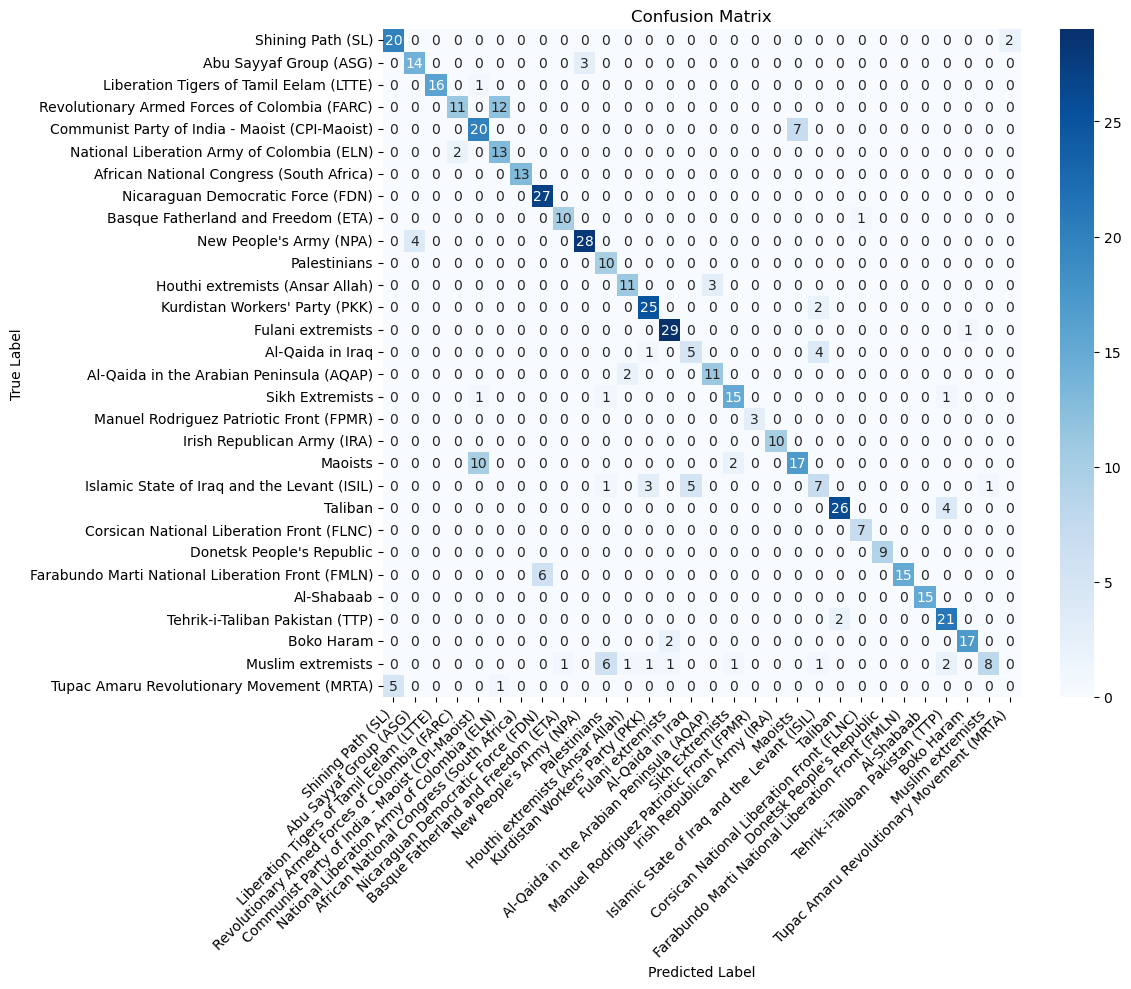

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(targets, preds)
plt.figure(figsize=(12, 10))  # Adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"confusion_matrix_gtd{partition}.png", dpi=300)

plt.show()



In [43]:
plt.savefig(f"confusion_matrix_gtd{partition}.png", dpi=300)


<Figure size 640x480 with 0 Axes>